Скорректируйте создание промптов в нейро-анализе собеседований из материалов занятия, добавив (где возможно) плюсы и минусы отнесения кандидата к тому или иному типу (если это применимо к данному пункту оценки), например, при оценке "Системность vs Суетология" должно поясняться, какие можно выделить аргументы "за" отнесение кандидата к системному типу, а какие - "против" и почему. Это должно отражаться во втором отчете - если данный параметр применим к конкретному пункту анализа.

# Схема проекта: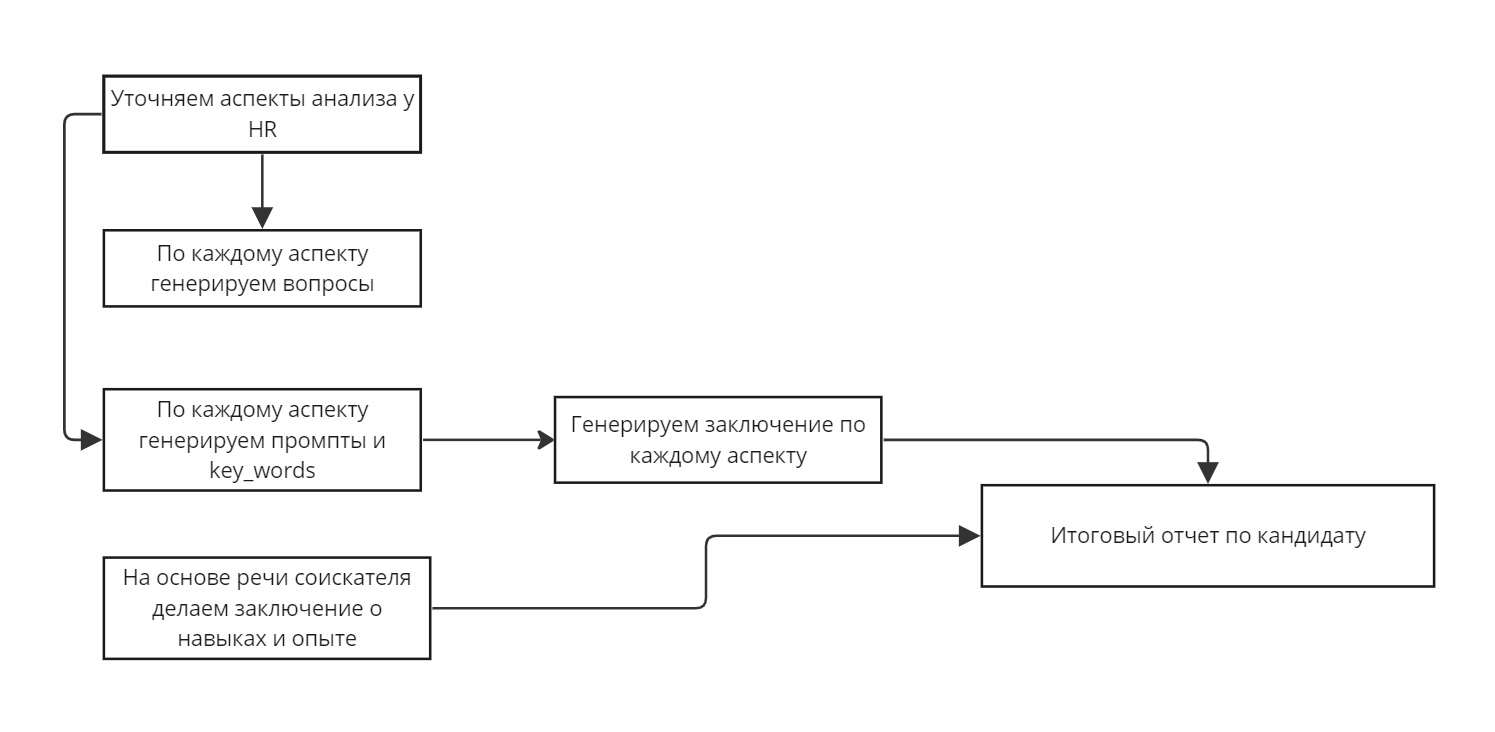

In [3]:
!pip install -q pydantic==2.10.6 tiktoken==0.7.0 openai==1.61.1 langchain==0.3.19 langchain_community==0.3.18 langchain-openai==0.3.6 faiss-cpu==1.8.0
from IPython.display import clear_output
clear_output()

In [5]:
import os
import re
from datetime import timedelta
import time
from IPython.display import HTML, clear_output
import subprocess
from pathlib import Path
import json
import ipywidgets as widgets
from IPython.display import display
from tqdm.auto import tqdm
import getpass
import pickle
#import torch
#import whisper
import openai
import codecs
from langchain.chains import ConversationChain         # Импортируем класс для создания цепочек диалогов
from openai import OpenAI
from langchain.memory import ConversationBufferMemory  # Импортируем класс для управления памятью диалогов
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma, FAISS
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
import pathlib
import tempfile
from IPython.display import HTML
import requests
# игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)
logging.getLogger("chromadb").setLevel(logging.ERROR)
import tiktoken

In [ ]:
from google.colab import drive
from google.colab import output
from google.colab import userdata
# инициируем ключи OpenAI через секрет
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key

In [6]:
# инициируем ключи OpenAI через секрет
#key = userdata.get('OPENAI_API_KEY')
#os.environ["OPENAI_API_KEY"] = key

key = os.environ["OPENAI_API_KEY"]
openai.api_key = key

BASE_URL = "https://openrouter.ai/api/v1"
API_KEY = key
MODEL = "deepseek/deepseek-r1-distill-qwen-32b:free"
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

In [8]:
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [9]:
url = "https://docs.google.com/document/d/14PDkow15jxyAXsm0l196aefbRPmpYd3v0iJe0sPupY8/edit?usp=sharing"
dialogue = load_document_text(url)

In [10]:
# выделяем то, что говорил HR и то, что говорил соискатель, в отдельные файлы - нам это понадобится в дальнейшем при анализе

hr_part = []  # Использование списка для хранения частей диалога HR
applicant_part = []  # Использование списка для хранения частей диалога соискателя
current_speaker = None

# Разделяем диалог по ролям
for line in dialogue.strip().split('\n'):
    if 'HR:' in line:
        current_speaker = 'HR'
        hr_part.append(line)  # Добавление строки в список
    elif 'Соискатель:' in line:
        current_speaker = 'Соискатель'
        applicant_part.append(line)  # Добавление строки в список
    else:
        if current_speaker == 'HR':
            hr_part[-1] += ' ' + line  # Добавление строки к последнему элементу списка
        elif current_speaker == 'Соискатель':
            applicant_part[-1] += ' ' + line  # Добавление строки к последнему элементу списка

# Объединение элементов списков в строки
hr_part = '\n'.join(hr_part)
applicant_part = '\n'.join(applicant_part)

In [41]:
def create_embedding(data, chunk_size, chunk_overlap=0):
    # Выбор метода разбиения текста на фрагменты
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, separators=["\n"])
    source_chunks = splitter.create_documents([data], metadatas=[{"meta": "meta"}])

    # Создание поискового индекса документов
    embeddings_model = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2"
     )
    search_index = FAISS.from_documents(source_chunks, embeddings_model)
    return search_index  # Возвращение поискового индекса

def insert_newlines(text: str, max_len: int = 170) -> str:
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

def answer_user_question(system_doc_text: str, knowledge_base_text, topic: str,
                         instructions: str, temperature: float, verbose: int, k: int, chunk_size: int, chunk_overlap: int, model: str) -> str:

    # Создаем индексы поиска
    knowledge_base_index = create_embedding(knowledge_base_text, chunk_size, chunk_overlap)
    # Извлечение наиболее похожих отрезков текста из базы знаний и получение ответа модели
    answer_text = answer_index(system_doc_text, topic, instructions, knowledge_base_index, temp=temperature, verbose=verbose, k=k, model=model)

    return insert_newlines(answer_text)

def answer_index(system, topic, instructions, search_index, temp=0, verbose=0, k=5, model=MODEL):

    # Selecting documents similar to the question
    # docs = search_index.similarity_search(topic, k=k)
    docs = search_index.similarity_search_with_score(topic, k=k)
    if verbose: print('===========================================')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'Отрывок текста №{i+1}\n=====================\n' + doc[0].page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content:\n ========================================\n',
                         re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок текста №{i+1} Оценка схожести: {doc[1]}\n=====================\n' + doc[0].page_content + '\n' for i, doc in enumerate(docs)])))

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instructions}\n\nТексты для анализа:\n{message_content}"}
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    answer = completion.choices[0].message.content
    return answer  # возвращает ответ вместо его вывода


def answer_user_question_from_answer(system, instructions, answers_content, temp=0, verbose=0, model=MODEL):

    if verbose: print('===========================================')
    if verbose: print(f'Результаты анализа:\n{answers_content}')
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instructions}\n\nРезультаты анализа:\n{answers_content}"}
    ]

    if verbose: print('===========================================\n')

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    return insert_newlines(answer)  # возвращает ответ вместо его вывода

def simple_gpt_answer(system, user_assist, assistant, user, temp=0, model=MODEL):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": user_assist},
        {'role':'assistant', 'content': assistant},
        {"role": "user", "content": f"{user}"}

    ]
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    return insert_newlines(answer)  # возвращает ответ вместо его вывода

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens



In [ ]:
HR_requests = []  # Инициализация пустого списка для хранения строк

while True:
    user_input = input("Введите ключевые аспекты, по которым будут анализироваться слова соискателя на должность (или напишите 'exit' для завершения): ")
    if user_input.lower() == 'exit':
        break
    HR_requests.append(user_input)

Введите ключевые аспекты, по которым будут анализироваться слова соискателя на должность (или напишите 'exit' для завершения): exit


In [13]:
HR_requests = [
    "К какой из ролей Адизеса относится соискатель, насколько хорошо соискатель адаптируется к различным ситуациям в команде и какие управленческие качества он проявляет",
    "Оценка способности кандидата к систематическому подходу в работе по сравнению с неструктурированным и хаотичным стилем. Это включает анализ, как кандидат планирует и организует свою работу, управляет временем и ресурсами, а также его способность к сосредоточенному выполнению задач без отвлечения на мелочи. Цель – понять, насколько кандидат склонен к систематическому решению задач и избеганию непродуктивной суеты.",
    "Определение, насколько кандидат фокусируется на конечных результатах или на процессе их достижения. Это помогает понять, как кандидат подходит к выполнению задач, решению проблем и достижению целей.",
    "Оценка способности кандидата быть инициатором новых проектов или эффективным продолжателем уже начатых процессов. Это помогает определить, насколько хорошо кандидат справится с задачами, требующими начальной творческой инициативы, в сравнении с задачами, требующими поддержания и развития существующих процессов.",
    "Анализ амбиций кандидата и его готовности сталкиваться со сложными и амбициозными задачами, насколько соискатель стремится к профессиональному росту и развитию, а также его способность принимать и успешно реализовывать вызовы и сложные задания",
    "Оценка способности кандидата адаптироваться к быстро меняющимся условиям работы и управлять стрессом, как кандидат справляется с неожиданными ситуациями, критикой, трудностями и давлением",
    "Анализ способности кандидата брать на себя ответственность за результаты своих действий и проектов, включая как успехи, так и неудачи, насколько кандидат склонен признавать свою роль в достижениях и поражениях, а также его готовность учиться на ошибках и конструктивно реагировать на обратную связь.",
    "Оценка того, как кандидат расставляет приоритеты между работой, семьей, доходом и комфортной жизнью",
    "Как соискатель взаимодействует с коллегами и другими отделами",
    "Способность соискателя самостоятельно принимать решения и проявлять инициативу"
]

In [14]:
system_QG = "Ты-помощник HR в компании 'Университет искусственного интеллекта'. Ты всегда точно следуешь инструкциям"
user_assist_QG = """Сгенерируй несколько вопросов, при помощи которых HR во время собеседования на позицию помощника маркетолога мог бы было выявить у соискателя следующий аспект:
способность кандидата генерировать новые идеи, предлагать нестандартные решения и быть открытым для инноваций"""
assist_QG = """Расскажите о ситуации, когда вам удалось успешно решить проблему нестандартным способом.
Приведите пример, когда вы предложили новаторское решение для улучшения процесса или продукта в вашей предыдущей работе.
Как вы подходите к генерации новых идей в рамках маркетинговой кампании?
Опишите проект или задачу, где вы действовали за рамками установленных процедур или стандартов.
Можете ли вы привести пример, когда ваши инновационные идеи были успешно реализованы?"""
user_QG = "Сгенерируй несколько вопросов, при помощи которых HR во время собеседования на позицию помощника маркетолога мог бы было выявить у соискателя следующий аспект: {i}"
questions = []
for i in HR_requests:
    # Формируем строку , подставляя текущий элемент из HR_requests вместо {i}
    user_prompt_questions = user_QG.format(i=i)

    # Вызываем функцию simple_gpt_answer с обновленной строкой user_prompt_writer_modified
    ans = simple_gpt_answer(system_QG, user_assist_QG, assist_QG, user_prompt_questions, temp=0, model=MODEL)

    # Добавляем полученный ответ в список prompts
    questions.append(ans)

In [15]:
system_prompt_writer = """Ты-копирайтер, на 100% точно выполняющий инструкции. В итоге должен получиться список строк: в первом элементе списка - инструкция по созданию двух отчетов,
 во втором - список ключевых слов. Два отчета должны быть в следующем формате: первый отчет - краткий и концентрированный анализ, второй отчет - детальный, с цитатами и анализом плюсов/минусов"""

user_assist = """я готовлю программу по анализу собеседования на должность помощника маркетолога по нескольким пунктам. Тебе нужно написать инструкцию для анализа следующего
аспекта:  анализ способности кандидата генерировать новые идеи, предлагать нестандартные решения и быть открытым для инноваций. В итоге должен быть список из 2 элементов: инструкция
и ключевые слова, по которым в диалоге можно было бы выявить фразы соискателя по теме: анализ способности кандидата генерировать новые идеи, предлагать нестандартные
решения и быть открытым для инноваций. Важно: сделай все в формате: список с инструкцией (2 отчета), ключевые слова. Первый отчет должен быть кратким и только по существу, в 2-3
предложениях, а второй отчет - детальный, развернутый анализ, с цитатами кандидата и оценкой плюсов/минусов отнесения кандидата к определённому типу. Укажи аргументы "за" и "против", обосновав каждое."""

assistant = """['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в паре предложений, оцени, насколько кандидат способен быть креативным и инновационным в своей работе.
Второй отчет: Проанализируй детально способности кандидата генерировать новые идеи, предлагать нестандартные решения и быть открытым для инноваций. Определи плюсы и минусы отнесения кандидата к креативному типу:
- Плюсы: фразы, демонстрирующие инициативность, эксперименты, успешные примеры
- Минусы: отсутствие примеров, склонность к рутине, неготовность к рискам
Цитируй ключевые высказывания кандидата, которые подтверждают или опровергают гипотезу. Опиши, как эти качества соответствуют или противоречат требованиям должности.',
'Креативность, инновации, эксперименты, нестандартные решения, инициатива, открытость, риск, рутинные задачи, творческий подход, гибкость']"""

user = """я готовлю программу по анализу собеседования на должность помощника маркетолога по нескольким пунктам. Тебе нужно написать инструкцию для анализа следующего
аспекта:  {i}. В итоге должен быть список из 2 элементов: инструкция и ключевые слова, по которым в диалоге можно было бы выявить фразы соискателя по теме: {i}
Важно: сделай все в формате: список с инструкцией (2 отчета), ключевые слова. Первый отчет должен быть кратким и только по существу, в 2-3
предложениях, а второй отчет - детальный, развернутый анализ, с цитатами кандидата и оценкой плюсов/минусов отнесения кандидата к определённому типу. Укажи аргументы "за" и "против", обосновав каждое. Основывайся только на диалоге."""

prompts = []
for i in HR_requests:
    user_prompt_writer_modified = user.format(i=i)
    ans = simple_gpt_answer(system_prompt_writer, user_assist, assistant, user_prompt_writer_modified, temp=0, model=MODEL)
    prompts.append(ans)

In [16]:
prompts

[" ['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в паре предложений, определи, к какой из ролей Адизеса относится соискатель, насколько хорошо он адаптируется\n к различным ситуациям в команде и какие управленческие качества он проявляет. Второй отчет: Проанализируй детально, к какой из ролей Адизеса относится соискатель,\n насколько хорошо он адаптируется к различным ситуациям в команде и какие управленческие качества он проявляет. Определи плюсы и минусы отнесения кандидата к\n определённому типу: - Плюсы: фразы, демонстрирующие гибкость, способность работать в команде, умение адаптироваться - Минусы: склонность кrigidity, отсутствие примеров\n адаптации, неумение взаимодействовать с командой Цитируй ключевые высказывания кандидата, которые подтверждают или опровергают гипотезу. Опиши, как эти качества\n соответствуют или противоречат требованиям должности.', 'Адаптивность, гибкость, командная работа, адаптация, управленческие качества, взаимодействие, лидерские\n качес

In [22]:
import ast
# Замена переносов строк на пробелы
modified_list = [item.replace('\n', ' ') for item in prompts]

# Преобразование каждой строки в список
#converted_list = [ast.literal_eval(item) for item in modified_list]
converted_list = []
for item in modified_list:
    try:
        # Удаляем непечатаемые символы перед парсингом
        cleaned_item = ''.join(char for char in item if char.isprintable())
        converted = ast.literal_eval(cleaned_item)
        converted_list.append(converted)
    except Exception as e:
        print(f"Ошибка в элементе: {item[:50]}... \nОшибка: {str(e)}")

print(converted_list)

#print(converted_list)

Ошибка в элементе:  ['Напиши 2 отчета: Первый отчет: кратко и концент... 
Ошибка: unterminated string literal (detected at line 1) (<unknown>, line 1)
Ошибка в элементе:  ### Инструкция: 1. **Первый отчет (краткий):** Оц... 
Ошибка: invalid syntax (<unknown>, line 1)
Ошибка в элементе:  ### Instructions for Analysis 1. **First Report (... 
Ошибка: invalid syntax (<unknown>, line 1)
Ошибка в элементе:  ['Напиши 2 отчета:\ \ Первый отчет: кратко и конц... 
Ошибка: unexpected character after line continuation character (<unknown>, line 1)
Ошибка в элементе:  ['Напиши 2 отчета: Первый отчет: кратко и концент... 
Ошибка: unterminated string literal (detected at line 1) (<unknown>, line 1)
Ошибка в элементе:  ### Instructions for Analysis: 1. **Analysis of t... 
Ошибка: invalid syntax (<unknown>, line 1)
[['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в паре предложений, оцени, насколько кандидат способен быть инициатором новых проектов или эффективным  продолжателем уже начатых

In [23]:
# таким образом будем обращаться к элементам нашего списка - к промптам и ключевым словам
converted_list[0][1]

'инициатива, новые проекты, инициатор, continuator, развитие процессов, поддержание, инициативные действия,  запуск, рутинные задачи, изменения'

In [24]:
converted_list[0][0]

'Напиши 2 отчета: Первый отчет: кратко и концентрированно, в паре предложений, оцени, насколько кандидат способен быть инициатором новых проектов или эффективным  продолжателем уже начатых процессов. Укажи, какие из его качеств соответствуют требованиям должности. Второй отчет: Проанализируй способности кандидата быть инициатором  новых проектов или эффективным продолжателем уже начатых процессов. Определи плюсы и минусы отнесения кандидата к типу "инициатор" или "continuator": - Плюсы: фразы,  демонстрирующие инициативность, успешные примеры запуска проектов, способность развивать существующие процессы - Минусы: отсутствие примеров запуска проектов, склонность  к поддержанию рутины, неготовность к изменениям Цитируй ключевые высказывания кандидата, которые подтверждают или опровергают гипотезу. Опиши, как эти качества  соответствуют или противоречат требованиям должности.'

In [25]:
#@title Подсчет токенов и их соотношение в диалоге между клиентом и менджером
num_token_dialog = num_tokens_from_string(dialogue, encoding_name="cl100k_base")
num_token_applicant = num_tokens_from_string(applicant_part, encoding_name="cl100k_base")
num_token_HR = num_tokens_from_string(hr_part, encoding_name="cl100k_base")
print('Токенов в Диалог: ', num_token_dialog)
print('Токенов в Соискатель +: ', num_token_applicant)
print('Токенов в HR +: ', num_token_HR)

# Проверка на нулевое общее количество токенов в диалоге для избежания деления на ноль
if num_token_dialog > 0:
    percent_applicant = (num_token_applicant * 100) / num_token_dialog
    percent_HR = (num_token_HR * 100) / num_token_dialog
    print("Процент токенов Соискатель: ", round(percent_applicant, 2), '%')
    print("Процент токенов HR: ", round(percent_HR, 2), '%')
else:
    print("Диалог не содержит токенов.")

Токенов в Диалог:  5042
Токенов в Соискатель +:  4004
Токенов в HR +:  1039
Процент токенов Соискатель:  79.41 %
Процент токенов HR:  20.61 %


In [31]:
#@title 1.Определение, к какой из ролей Адизеса относится соискатель
model = "deepseek/deepseek-r1-distill-qwen-32b:free" #@param ["deepseek/deepseek-r1-distill-qwen-32b:free", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
content = 'Соискатель +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 816 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
num_fragment = 8 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[0][0]
topicphrase = converted_list[0][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part
output1 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model)
print("\nОтвет:\n", output1)


Ответ:
  ### Первый отчет: Кандидат демонстрирует способность быть инициатором новых проектов, так как он проявляет интерес к развитию и поиску новых источников, а также успешно
 продвигается в карьерном плане. Его качества, такие как многозадачность и стремление к росту, соответствуют требованиям должности. --- ### Второй отчет: #### Плюсы: -
 **Инициативность**: Кандидат упоминает, что искал новые источники для размещения вакансий, включая Телеграм и блогеров: *"мы пыталась найти новые источники, помимо
 HeadHunter, Авито, где, ну, я там, понятное дело, тоже размещалась, а именно другие. Какие источники? То есть это Телеграм-канал, это Инстаграм, писала, обращалась к
 блогерам..."* Это показывает способность находить нестандартные решения и развивать существующие процессы. - **Развитие карьеры**: Кандидат вырос до помощника
 операционного директора за полгода: *"из собственных достижений, то, наверное, я бы соотнесла к собственному достижению работы в прошлой, ну, конкретно в послед

In [32]:
#@title 2.Системность vs Суетология
model = "deepseek/deepseek-r1-distill-qwen-32b:free" #@param ["deepseek/deepseek-r1-distill-qwen-32b:free", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 688 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 8 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[1][0]
topicphrase = converted_list[1][1]


if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output2 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output2)


Ответ:
  ### Первый отчет: Кандидат демонстрирует способность справляться с многозадачностью и адаптироваться к новым инструментам, что свидетельствует о его гибкости. Однако
 отсутствие конкретных примеров преодоления стрессовых ситуаций вызывает сомнения в его стрессоустойчивости. --- ### Второй отчет: Кандидат демонстрирует способность
 адаптироваться к изменениям, однако его стрессоустойчивость требует дополнительного анализа. #### Плюсы: 1. **Гибкость**: Кандидат успешно адаптировался к работе с
 различными платформами, такими как Телеграм и Инстаграм, а также сотрудничеству с блогерами (Отрывок №2). Это показывает способность находить новые источники и решать
 задачи в условиях изменения условий работы. 2. **Развитие и обучение**: Кандидат проходит обучение в инфобизнесе, что демонстрирует его стремление к росту и адаптации к
 новым тенденциям (Отрывок №4). 3. **Карьера**: Карьерный рост от координатора до помощника операционного директора (Отрывок №7) показывает способность кан

In [33]:
#@title 3. Ориентация на процесс или на результат
model = "deepseek/deepseek-r1-distill-qwen-32b:free" #@param ["deepseek/deepseek-r1-distill-qwen-32b:free", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 712 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[2][0]
topicphrase = converted_list[2][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output3 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output3)


Ответ:
  ### Отчет 1: Оценка способности кандидата брать на себя ответственность Кандидат демонстрирует способность признавать свою роль в достижениях, такие как рост с
 координатора до помощника операционного директора, и адаптироваться к новым задачам, например, расширение работы с СНГ. Однако он не конкретно говорит о неудачах, что
 может свидетельствовать о недостаточной готовности анализировать ошибки. Его готовность учиться и реагировать на обратную связь остается неочевидной. --- ### Отчет 2:
 Детальный анализ способности кандидата брать на себя ответственность #### Плюсы: 1. **Активность и инициатива**: Кандидат описывает процесс подбора персонала через
 различные платформы, что демонстрирует его способность искать новые источники и быть инициативным. *Цитата:* "Я пыталась найти новые источники, помимо HeadHunter, Авито,
 где, ну, я там, понятное дело, тоже размещалась, а именно другие. Какие источники? То есть это Телеграм-канал, это Инстаграм, писала, обращалась к блогерам, 

In [34]:
#@title 4. Склонность к инициации или к продолжению процессов
model = "deepseek/deepseek-r1-distill-qwen-32b:free" #@param ["deepseek/deepseek-r1-distill-qwen-32b:free", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 800 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 9 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[3][0]
topicphrase = converted_list[3][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output4 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output4)


Ответ:
  ### Первый отчет: Соискатель демонстрирует способность к сотрудничеству, координации и пониманию ролей, особенно в процессах поиска персонала и работе с различными
 каналами. Он активно взаимодействует с коллегами, координирует действия и демонстрирует готовность к многозадачной работе. --- ### Второй отчет: #### Плюсы: 1.
 **Готовность к сотрудничеству**: Соискатель демонстрирует способность работать с различными источниками, такими как Телеграм-каналы, Инстаграм и блогеры, чтобы найти
 персонал. Например: > "мы обращались к блогерам с просьбой посодействовать, пытались заказать рекламу у блогеров". Это показывает готовность к сотрудничеству и
 координации. 2. **Успешное взаимодействие**: Он успешно находил сотрудников из СНГ, используя переводчиков и людей, знающих языки Узбекистана и Кыргызстана. > "мы искали
 сотрудников, либо нанимали человека, который непосредственно владеет там языком Узбекистана, Кыргызстана и прочее". Это подтверждает способность координировать дейст

In [42]:
#@title Отчет о навыках соискателя
model = "deepseek/deepseek-r1-distill-qwen-32b:free" #@param ["deepseek/deepseek-r1-distill-qwen-32b:free", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 \u0437\u0430\u043A\u043B\u044E\u0447\u0430\u0435\u0442\u0441\u044F \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u043C\u0435\u0436\u0434\u0443 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u0435\u043C \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430. \u041E\u0441\u043D\u043E\u0432\u044B\u0432\u0430\u044F\u0441\u044C \u043D\u0430 \u044D\u0442\u043E\u043C \u0434\u0438\u0430\u043B\u043E\u0433\u0435, \u0442\u0435\u0431\u0435 \u043D\u0435\u043E\u0431\u0445\u043E\u0434\u0438\u043C\u043E \u0441\u043E\u0441\u0442\u0430\u0432\u0438\u0442\u044C \u043E\u0442\u0447\u0435\u0442, \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u043C \u0442\u044B \u043E\u0446\u0435\u043D\u0438\u0432\u0430\u0435\u0448\u044C \u0438 \u043E\u043F\u0438\u0441\u044B\u0432\u0430\u0435\u0448\u044C \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0443\u043C\u0435\u043D\u0438\u044F \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F, \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0432 \u0445\u043E\u0434\u0435 \u0431\u0435\u0441\u0435\u0434\u044B. \u041F\u043E\u0434\u0447\u0435\u0440\u043A\u043D\u0438, \u043A\u0430\u043A\u0438\u0435 \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0437\u043D\u0430\u043D\u0438\u044F \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C \u043F\u0440\u043E\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0438\u0440\u043E\u0432\u0430\u043B, \u0438 \u043A\u0430\u043A \u044D\u0442\u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u043F\u043E\u043B\u0435\u0437\u043D\u044B \u0434\u043B\u044F \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u0438 \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430." #@param {type:"string"}
instructions = "\u041E\u043F\u0440\u0435\u0434\u0435\u043B\u0438 \u0438 \u043F\u0435\u0440\u0435\u0447\u0438\u0441\u043B\u0438 \u043A\u043B\u044E\u0447\u0435\u0432\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0443\u043C\u0435\u043D\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C \u043F\u0440\u043E\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0438\u0440\u043E\u0432\u0430\u043B \u0432\u043E \u0432\u0440\u0435\u043C\u044F \u0434\u0438\u0430\u043B\u043E\u0433\u0430. \u042D\u0442\u043E \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u0442\u0435\u0445\u043D\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u0442\u0430\u043A\u0438\u0435 \u043A\u0430\u043A \u0437\u043D\u0430\u043D\u0438\u0435 \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0435\u043D\u043D\u044B\u0445 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u043E\u0432\u044B\u0445 \u0438\u043D\u0441\u0442\u0440\u0443\u043C\u0435\u043D\u0442\u043E\u0432 \u0438\u043B\u0438 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C, \u0430\u043D\u0430\u043B\u0438\u0442\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0438, \u043A\u0440\u0435\u0430\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u044C, \u0443\u043C\u0435\u043D\u0438\u0435 \u0440\u0430\u0431\u043E\u0442\u0430\u0442\u044C \u0432 \u043A\u043E\u043C\u0430\u043D\u0434\u0435, \u043A\u043E\u043C\u043C\u0443\u043D\u0438\u043A\u0430\u0442\u0438\u0432\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u043E\u0440\u0433\u0430\u043D\u0438\u0437\u0430\u0446\u0438\u043E\u043D\u043D\u044B\u0435 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0438 \u0438 \u0442.\u0434. \u041E\u0431\u044A\u044F\u0441\u043D\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u044D\u0442\u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0443\u043C\u0435\u043D\u0438\u044F \u0432\u0430\u0436\u043D\u044B \u0434\u043B\u044F \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u0438 \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430. \u041D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \u043A\u0430\u043A \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u044C \u043A \u0430\u043D\u0430\u043B\u0438\u0437\u0443 \u0434\u0430\u043D\u043D\u044B\u0445 \u043C\u043E\u0436\u0435\u0442 \u043F\u043E\u043C\u043E\u0447\u044C \u0432 \u043E\u043F\u0442\u0438\u043C\u0438\u0437\u0430\u0446\u0438\u0438 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u043E\u0432\u044B\u0445 \u0441\u0442\u0440\u0430\u0442\u0435\u0433\u0438\u0439, \u0438\u043B\u0438 \u043A\u0430\u043A \u043A\u043E\u043C\u043C\u0443\u043D\u0438\u043A\u0430\u0442\u0438\u0432\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u043C\u043E\u0433\u0443\u0442 \u0441\u043F\u043E\u0441\u043E\u0431\u0441\u0442\u0432\u043E\u0432\u0430\u0442\u044C \u044D\u0444\u0444\u0435\u043A\u0442\u0438\u0432\u043D\u043E\u0439 \u0440\u0430\u0431\u043E\u0442\u0435 \u0432 \u043A\u043E\u043C\u0430\u043D\u0434\u0435 \u0438 \u0432\u0437\u0430\u0438\u043C\u043E\u0434\u0435\u0439\u0441\u0442\u0432\u0438\u044E \u0441 \u043A\u043B\u0438\u0435\u043D\u0442\u0430\u043C\u0438. \u0421\u0444\u043E\u0440\u043C\u0443\u043B\u0438\u0440\u0443\u0439 \u0441\u0432\u043E\u0438 \u0432\u044B\u0432\u043E\u0434\u044B \u043E \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u0435, \u043E\u0441\u043D\u043E\u0432\u044B\u0432\u0430\u044F\u0441\u044C \u043D\u0430 \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u044B\u0445 \u0434\u0430\u043D\u043D\u044B\u0445. \u0415\u0441\u043B\u0438 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u043D\u0435\u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u043F\u0440\u0435\u0434\u043B\u043E\u0436\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u044B, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043C\u043E\u0433\u043B\u0438 \u0431\u044B \u043F\u043E\u043C\u043E\u0447\u044C \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u0434\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u043A\u043E\u043C\u043F\u0435\u0442\u0435\u043D\u0446\u0438\u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F, \u0442\u0430\u043A\u0438\u0435 \u043A\u0430\u043A \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u043E \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0445 \u043C\u0435\u0442\u043E\u0434\u0438\u043A\u0430\u0445 \u0440\u0430\u0431\u043E\u0442\u044B, \u043E \u043F\u043E\u0434\u0445\u043E\u0434\u0430\u0445 \u043A \u0440\u0435\u0448\u0435\u043D\u0438\u044E \u0442\u0438\u043F\u043E\u0432\u044B\u0445 \u0437\u0430\u0434\u0430\u0447 \u0432 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u0435, \u043E \u043F\u043E\u043D\u0438\u043C\u0430\u043D\u0438\u0438 \u0442\u0440\u0435\u043D\u0434\u043E\u0432 \u043E\u0442\u0440\u0430\u0441\u043B\u0438 \u0438 \u0442.\u0434." #@param {type:"string"}

skills_report = answer_user_question_from_answer(system_prompt, instructions, applicant_part,
                               temperature, 0, model)

print("\nОтвет:\n", skills_report)


Ответ:
  ### Оценка навыков и умений соискателя для должности помощника маркетолога #### 1. **Ключевые навыки и умения, продемонстрированные соискателем:** - **Многозадачность и
 адаптивность:** - Соискатель демонстрирует способность работать в режиме многозадачности, что важно для должности помощника маркетолога, где часто приходится
 одновременно заниматься несколькими проектами и задачами. - Он также адаптировался к изменениям в графике работы, начиная с полной работы в офисе, переходя к гибридной
 модели. - **Коммуникативные навыки:** - Соискатель смог договориться с коллегами и операционным директором по сложной задаче, что показывает его способность эффективно
 взаимодействовать с людьми и находить общий язык. - Он также общался с блогерами и использовал социальные сети для поиска сотрудников, что демонстрирует навыки
 коммуникации в цифровых средах. - **Аналитические способности и проблемное решение:** - Соискатель оптимизировал процесс обработки заявок, разработав систему с
 и

In [44]:
#@title Итоговый отчет
model = "deepseek/deepseek-r1-distill-qwen-32b:free" #@param ["deepseek/deepseek-r1-distill-qwen-32b:free", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u041A\u0430\u043A HR, \u0442\u044B \u043E\u0446\u0435\u043D\u0438\u0432\u0430\u0435\u0448\u044C \u043E\u0442\u0447\u0435\u0442\u044B, \u0441\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0434\u0440\u0443\u0433\u0438\u043C HR-\u0441\u043F\u0435\u0446\u0438\u0430\u043B\u0438\u0441\u0442\u043E\u043C, \u043F\u043E \u0438\u0442\u043E\u0433\u0430\u043C \u0441\u043E\u0431\u0435\u0441\u0435\u0434\u043E\u0432\u0430\u043D\u0438\u044F \u0441 \u043A\u0430\u043D\u0434\u0438\u0434\u0430\u0442\u043E\u043C \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \"\u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0418\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0418\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0446\u0435\u043B\u044C - \u0441\u043E\u0441\u0442\u0430\u0432\u0438\u0442\u044C \u0438\u0442\u043E\u0433\u043E\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442, \u0438\u043D\u0442\u0435\u0433\u0440\u0438\u0440\u0443\u044F \u043A\u043B\u044E\u0447\u0435\u0432\u0443\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0438\u0437 \u043F\u0440\u0435\u0434\u044B\u0434\u0443\u0449\u0438\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432, \u0438\u0437\u0431\u0435\u0433\u0430\u044F \u043F\u043E\u0432\u0442\u043E\u0440\u043E\u0432 \u0438 \u0444\u043E\u043A\u0443\u0441\u0438\u0440\u0443\u044F\u0441\u044C \u043D\u0430 \u043D\u0430\u0438\u0431\u043E\u043B\u0435\u0435 \u0432\u0430\u0436\u043D\u044B\u0445 \u0430\u0441\u043F\u0435\u043A\u0442\u0430\u0445." #@param {type:"string"}
instructions = "\u0421\u043E\u0441\u0442\u0430\u0432\u044C \u0438\u0442\u043E\u0433\u043E\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442, \u0438\u043D\u0442\u0435\u0433\u0440\u0438\u0440\u0443\u044F \u043A\u043B\u044E\u0447\u0435\u0432\u0443\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0438\u0437 \u043F\u0440\u0435\u0434\u044B\u0434\u0443\u0449\u0438\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432, \u0438\u0437\u0431\u0435\u0433\u0430\u044F \u043F\u043E\u0432\u0442\u043E\u0440\u043E\u0432 \u0438 \u0444\u043E\u043A\u0443\u0441\u0438\u0440\u0443\u044F\u0441\u044C \u043D\u0430 \u043D\u0430\u0438\u0431\u043E\u043B\u0435\u0435 \u0432\u0430\u0436\u043D\u044B\u0445 \u0430\u0441\u043F\u0435\u043A\u0442\u0430\u0445. \u041F\u0440\u043E\u0446\u0435\u0441\u0441 \u0441\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u0438\u044F \u0438\u0442\u043E\u0433\u043E\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: 1. \u0410\u043D\u0430\u043B\u0438\u0437 \u0418\u0441\u0445\u043E\u0434\u043D\u044B\u0445 \u041E\u0442\u0447\u0435\u0442\u043E\u0432: \u0412\u043D\u0438\u043C\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u0438\u0437\u0443\u0447\u0438 \u043F\u0440\u0435\u0434\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u043E\u0442\u0447\u0435\u0442\u044B, \u0432\u044B\u0434\u0435\u043B\u044F\u044F \u043E\u0441\u043D\u043E\u0432\u043D\u044B\u0435 \u043C\u043E\u043C\u0435\u043D\u0442\u044B, \u0442\u0430\u043A\u0438\u0435 \u043A\u0430\u043A \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430, \u043E\u043F\u044B\u0442 \u0438 \u0434\u043E\u0441\u0442\u0438\u0436\u0435\u043D\u0438\u044F \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F.  2. \u0412\u044B\u0434\u0435\u043B\u0435\u043D\u0438\u0435 \u041A\u043B\u044E\u0447\u0435\u0432\u043E\u0439 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438: \u041E\u043F\u0440\u0435\u0434\u0435\u043B\u0438 \u043D\u0430\u0438\u0431\u043E\u043B\u0435\u0435 \u0437\u043D\u0430\u0447\u0438\u043C\u044B\u0435 \u0444\u0430\u043A\u0442\u044B \u0438 \u043D\u0430\u0431\u043B\u044E\u0434\u0435\u043D\u0438\u044F \u043E \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u0435, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u0440\u044F\u043C\u043E \u0441\u0432\u044F\u0437\u0430\u043D\u044B \u0441 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C\u044E \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430. \u042D\u0442\u043E \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u0435\u0433\u043E \u0442\u0435\u0445\u043D\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u043E\u043F\u044B\u0442 \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \u0441\u0444\u0435\u0440\u0435 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u0430, \u043A\u0440\u0435\u0430\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u044C, \u0430\u043D\u0430\u043B\u0438\u0442\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0438, \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u044C \u043A \u043A\u043E\u043C\u0430\u043D\u0434\u043D\u043E\u0439 \u0440\u0430\u0431\u043E\u0442\u0435 \u0438 \u0434\u0440\u0443\u0433\u0438\u0435 \u0440\u0435\u043B\u0435\u0432\u0430\u043D\u0442\u043D\u044B\u0435 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430. 3. \u0421\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0435 \u041E\u0442\u0447\u0435\u0442\u0430: \u0421\u043E\u0441\u0442\u0430\u0432\u044C \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0443 \u0438\u0442\u043E\u0433\u043E\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430, \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u0439 \u0431\u0443\u0434\u0443\u0442 \u0447\u0435\u0442\u043A\u043E \u0440\u0430\u0437\u0433\u0440\u0430\u043D\u0438\u0447\u0435\u043D\u044B \u0440\u0430\u0437\u043B\u0438\u0447\u043D\u044B\u0435 \u0430\u0441\u043F\u0435\u043A\u0442\u044B \u043A\u0432\u0430\u043B\u0438\u0444\u0438\u043A\u0430\u0446\u0438\u0438 \u0438 \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u044B\u0445 \u043A\u0430\u0447\u0435\u0441\u0442\u0432 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F. \u041D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \u0440\u0430\u0437\u0434\u0435\u043B\u0438 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u043D\u0430 \u0440\u0430\u0437\u0434\u0435\u043B\u044B: \u043E\u0431\u0440\u0430\u0437\u043E\u0432\u0430\u043D\u0438\u0435 \u0438 \u043A\u0432\u0430\u043B\u0438\u0444\u0438\u043A\u0430\u0446\u0438\u044F, \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u043E\u043D\u0430\u043B\u044C\u043D\u044B\u0439 \u043E\u043F\u044B\u0442, \u043B\u0438\u0447\u043D\u044B\u0435 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438 \u043D\u0430\u0432\u044B\u043A\u0438. 4. \u0424\u043E\u0440\u043C\u0443\u043B\u0438\u0440\u043E\u0432\u043A\u0430 \u0412\u044B\u0432\u043E\u0434\u043E\u0432: \u041D\u0430 \u043E\u0441\u043D\u043E\u0432\u0435 \u0441\u043E\u0431\u0440\u0430\u043D\u043D\u043E\u0439 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u0441\u0444\u043E\u0440\u043C\u0443\u043B\u0438\u0440\u0443\u0439 \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0435 \u0432\u044B\u0432\u043E\u0434\u044B \u043E \u0441\u043E\u043E\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0438\u0438 \u043A\u0430\u043D\u0434\u0438\u0434\u0430\u0442\u0430 \u0442\u0440\u0435\u0431\u043E\u0432\u0430\u043D\u0438\u044F\u043C \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u0438. \u0423\u043A\u0430\u0436\u0438, \u043A\u0430\u043A\u0438\u0435 \u0435\u0433\u043E \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u0434\u0435\u043B\u0430\u044E\u0442 \u0435\u0433\u043E \u043F\u043E\u0434\u0445\u043E\u0434\u044F\u0449\u0438\u043C (\u0438\u043B\u0438 \u043D\u0435\u043F\u043E\u0434\u0445\u043E\u0434\u044F\u0449\u0438\u043C) \u0434\u043B\u044F \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \"\u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442\u0435 \u0418\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0418\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". 5. \u0420\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0438: \u0415\u0441\u043B\u0438 \u044D\u0442\u043E \u043D\u0435\u043E\u0431\u0445\u043E\u0434\u0438\u043C\u043E, \u0434\u0430\u0439 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0438 \u043E\u0442\u043D\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u043E \u0434\u0430\u043B\u044C\u043D\u0435\u0439\u0448\u0438\u0445 \u0448\u0430\u0433\u043E\u0432 - \u043D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \u043F\u0440\u0435\u0434\u043B\u043E\u0436\u0438\u0442\u044C \u043A\u0430\u043D\u0434\u0438\u0434\u0430\u0442\u0443 \u0432\u0442\u043E\u0440\u043E\u0435 \u0441\u043E\u0431\u0435\u0441\u0435\u0434\u043E\u0432\u0430\u043D\u0438\u0435 \u0441 \u0443\u0447\u0430\u0441\u0442\u0438\u0435\u043C \u0434\u0440\u0443\u0433\u0438\u0445 \u0447\u043B\u0435\u043D\u043E\u0432 \u043A\u043E\u043C\u0430\u043D\u0434\u044B, \u0437\u0430\u043F\u0440\u043E\u0441\u0438\u0442\u044C \u0434\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0435 \u0434\u043E\u043A\u0443\u043C\u0435\u043D\u0442\u044B \u0438\u043B\u0438 \u043F\u043E\u0440\u0442\u0444\u043E\u043B\u0438\u043E \u0440\u0430\u0431\u043E\u0442. 6. \u0418\u0442\u043E\u0433\u043E\u0432\u043E\u0435 \u041E\u0444\u043E\u0440\u043C\u043B\u0435\u043D\u0438\u0435: \u0423\u0431\u0435\u0434\u0438\u0441\u044C, \u0447\u0442\u043E \u0438\u0442\u043E\u0433\u043E\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442 \u043B\u0430\u043A\u043E\u043D\u0438\u0447\u0435\u043D, \u0447\u0435\u0442\u043A\u043E \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0438\u0440\u043E\u0432\u0430\u043D \u0438 \u0441\u0432\u043E\u0431\u043E\u0434\u0435\u043D \u043E\u0442 \u043D\u0435\u043D\u0443\u0436\u043D\u044B\u0445 \u043F\u043E\u0432\u0442\u043E\u0440\u0435\u043D\u0438\u0439. \u041E\u0442\u0447\u0435\u0442 \u0434\u043E\u043B\u0436\u0435\u043D \u0431\u044B\u0442\u044C \u043D\u0430\u043F\u0438\u0441\u0430\u043D \u044F\u0441\u043D\u044B\u043C \u0438 \u043F\u043E\u043D\u044F\u0442\u043D\u044B\u043C \u044F\u0437\u044B\u043A\u043E\u043C, \u0447\u0442\u043E\u0431\u044B \u0435\u0433\u043E \u043C\u043E\u0433\u043B\u0438 \u043B\u0435\u0433\u043A\u043E \u043F\u043E\u043D\u044F\u0442\u044C \u0438 \u0434\u0440\u0443\u0433\u0438\u0435 \u0447\u043B\u0435\u043D\u044B \u043A\u043E\u043C\u0430\u043D\u0434\u044B \u0438\u043B\u0438 \u0440\u0443\u043A\u043E\u0432\u043E\u0434\u0441\u0442\u0432\u043E \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438." #@param {type:"string"}


answers = " ".join([f"Анализ №{i+1}. {q}\n"  for i, q in enumerate([output1, output2, output3, output4, skills_report]) if len(q)]) # output5, output6, output7, output8, output9, output10, skills_report]) if len(q)])

final_report = answer_user_question_from_answer(system_prompt, instructions, answers,
                               temperature, 0, model)

print("\nОтвет:\n", final_report)


Ответ:
  ### Итоговый Отчет о Кандидате на Должность Помощника Маркетолога #### 1. Образование и Квалификация Кандидат имеет опыт работы в ритейле и сфере услуг, а также проходит
 обучение в области инфобизнеса и искусственного интеллекта. Его карьерный путь включает рост от координатора до помощника операционного директора за полгода. #### 2.
 Профессиональный Опыт - **Инициатива**: Кандидат успешно находил новые источники для размещения вакансий, сотрудничая с блогерами и используя платформы, такие как
 Телеграм и Инстаграм. - **Оптимизация**: Разработал систему для обработки заявок с использованием Yandex, что сократило время на выполнение задач. - **Международный
 опыт**: Работал над привлечением сотрудников из СНГ, координируя действия переводчиков и специалистов. #### 3. Личные Качества и Навыки - **Инициативность и Гибкость**:
 Способность адаптироваться к изменениям и находить нестандартные решения. - **Стремление к Развитию**: Продолжает обучение в новой области, показывая го